# Double Descent in Linear Regression

This notebook is based on a recent 
[paper](https://arxiv.org/abs/1912.02292) 
that observed a phenomenon dubbed "(model-based) double descent". 
To understand this idea, consider the bias-variance tradeoff 
from classical statistics. 
Roughly this says that as you increase the 
number of parameters in a model, 
the bias decreases at the cost of increasing the variance. 
This tells you to expect that as you increase 
model complexity by more parameters you should 
expect worse generalization since the model memorizes the data. 
On the contrary, it has been pointed out in this paper 
and references therein that test performance actually 
becomes better again after becoming worse. 
This notebook explores this effect.

In [1]:
# basics
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size' : 22,
                     'figure.figsize' : (15,10),
                     'figure.dpi' : 150})

# train/test split
from sklearn.model_selection import train_test_split

# tensorflow
from tensorflow.random import set_seed
from tensorflow.keras import Model
from tensorflow.keras.layers import *

In [2]:
# Generate data
x = np.random.uniform(0, 1, 100)
def get_data(x):
    period = 0.3
    sinusoid = lambda x, period : 0.2 * np.sin(2 * np.pi * x / period) + x
    y = sinusoid(x, period)
    return x, y
x, y = get_data(x)

In [3]:
# train-test split
np.random.seed(23)
test_proportion = 0.2
test_size = int(test_proportion * len(x))
test = np.random.randint(0, len(x)-1, test_size)
test = [x in test for x in range(len(x))]
train = np.logical_not(test)

x_train, y_train = x[train], y[train]
x_test, y_test = x[test], y[test]
train_data = (x_train, y_train)
test_data = (x_test, y_test)

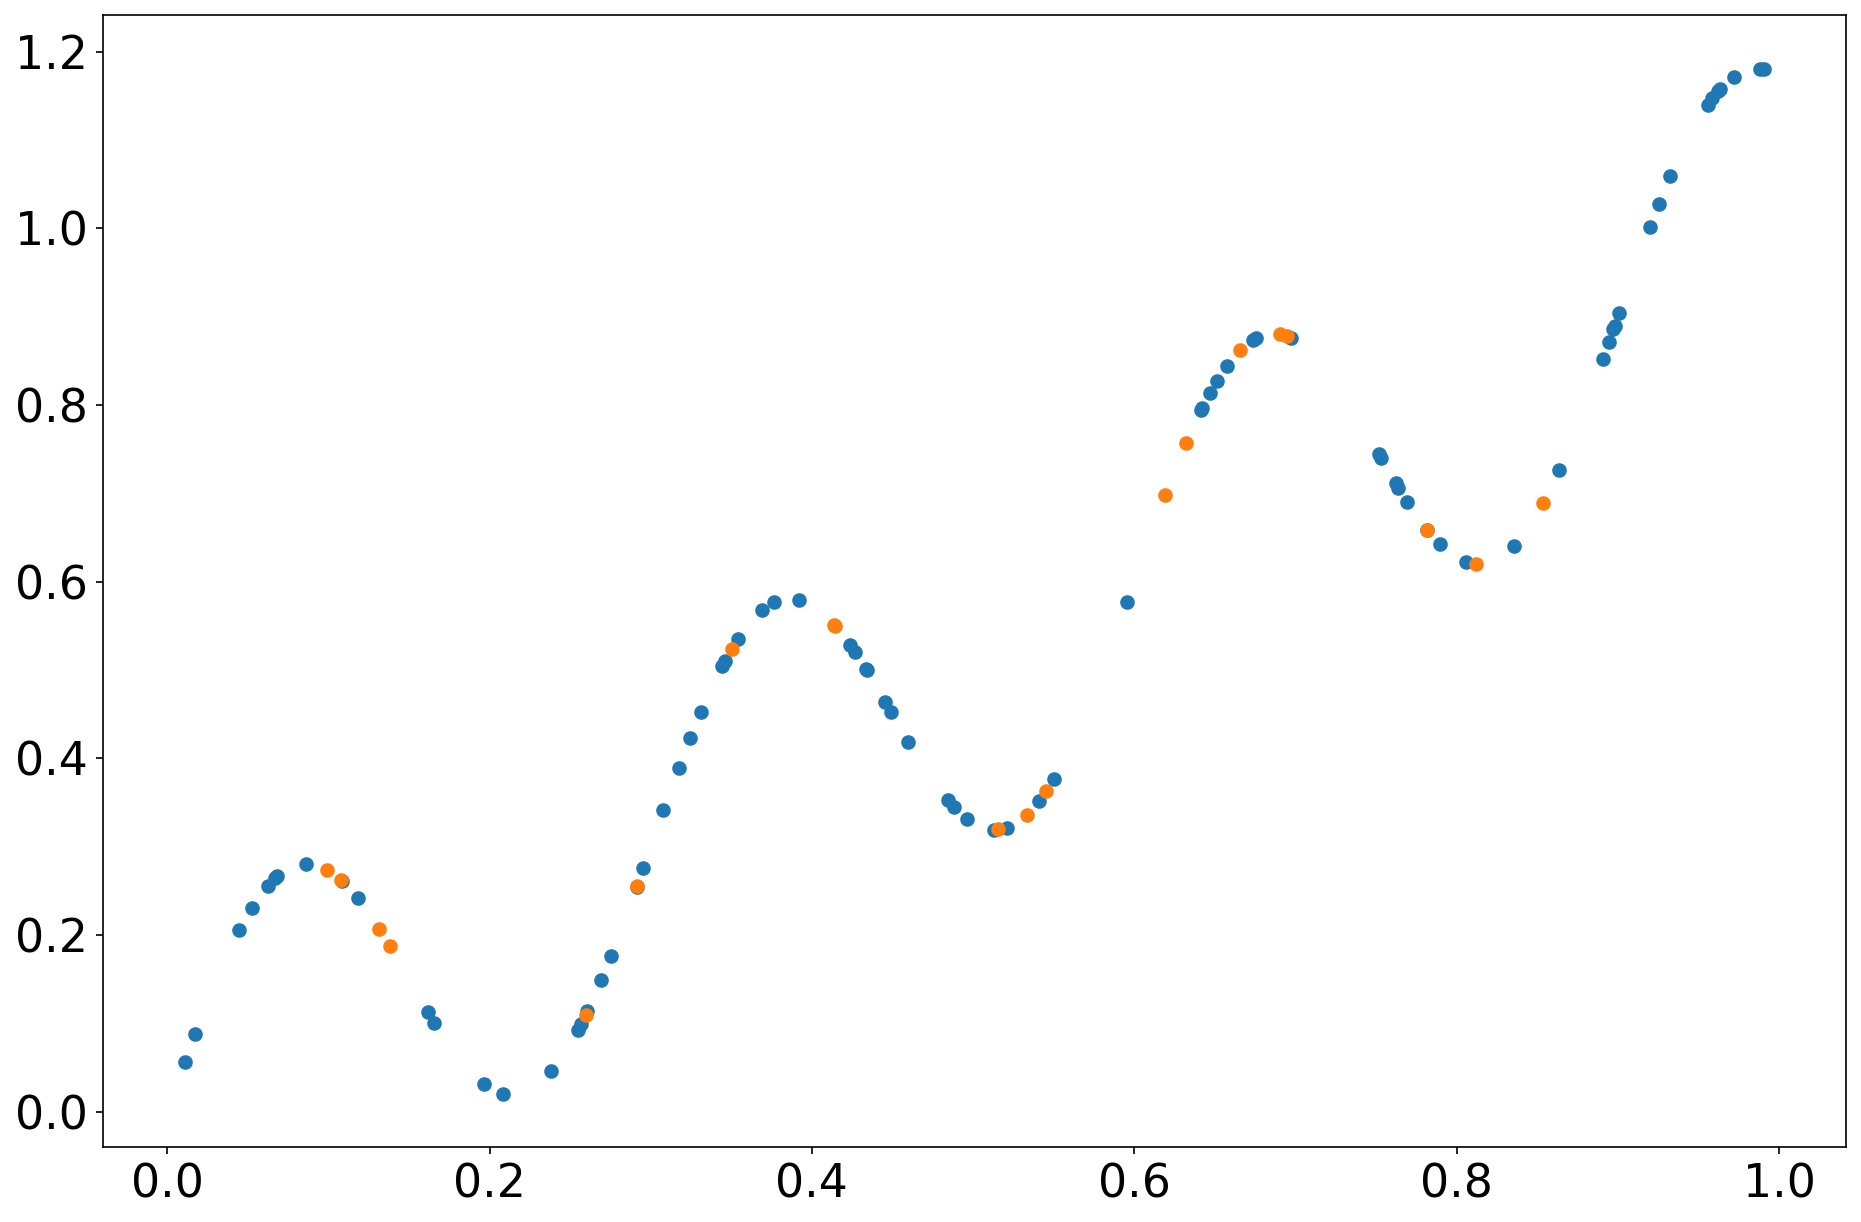

In [8]:
fig, ax = plt.subplots()
ax.scatter(train_data[0], train_data[1])
ax.scatter(test_data[0], test_data[1])
plt.show()
plt.close()

# Classical U-shape

The first goal will be to see the "U"-shape in the test loss as a function of the model complexity.

In [18]:
def train(train_data, test_data, hidden_units, epochs, verbose=False):
    
    # build model
    x = Input((1,))
    xx = Dense(hidden_units, 'tanh', name='hidden')(x)
    y = Dense(1, 'exponential')(xx)
    model = Model(x, y)

    # fit model
    set_seed(23)
    model.compile('adam', 'mae')
    model.fit(train_data[0], train_data[1], epochs=epochs, verbose=0)
    
    if verbose:
        model.summary()
        train_loss = model.evaluate(train_data[0], train_data[1], verbose=0)
        test_loss = model.evaluate(test_data[0], test_data[1], verbose=0)
        print('train loss:', train_loss)
        print('test loss:', test_loss)
    
    return model

Now let's plot the learned function.

In [19]:
def plot_model(x, model):
    _, y_true = get_data(x)
    y = model.predict(x)
    y_test_hat = model.predict(x_test)
    fig, ax = plt.subplots()
    ax.plot(x, y_true, label='true function')
    ax.plot(x, y, label='learned function')
    ax.scatter(x_test, y_test, label='test data')
    ax.scatter(x_test, y_test_hat, label='test predictions')
    ax.legend()
    plt.show()
    plt.close()
    
def train_and_plot(hidden_units, epochs):
    model = train(train_data, test_data, hidden_units, epochs)
    plot_model(np.linspace(0, 1, 100), model)

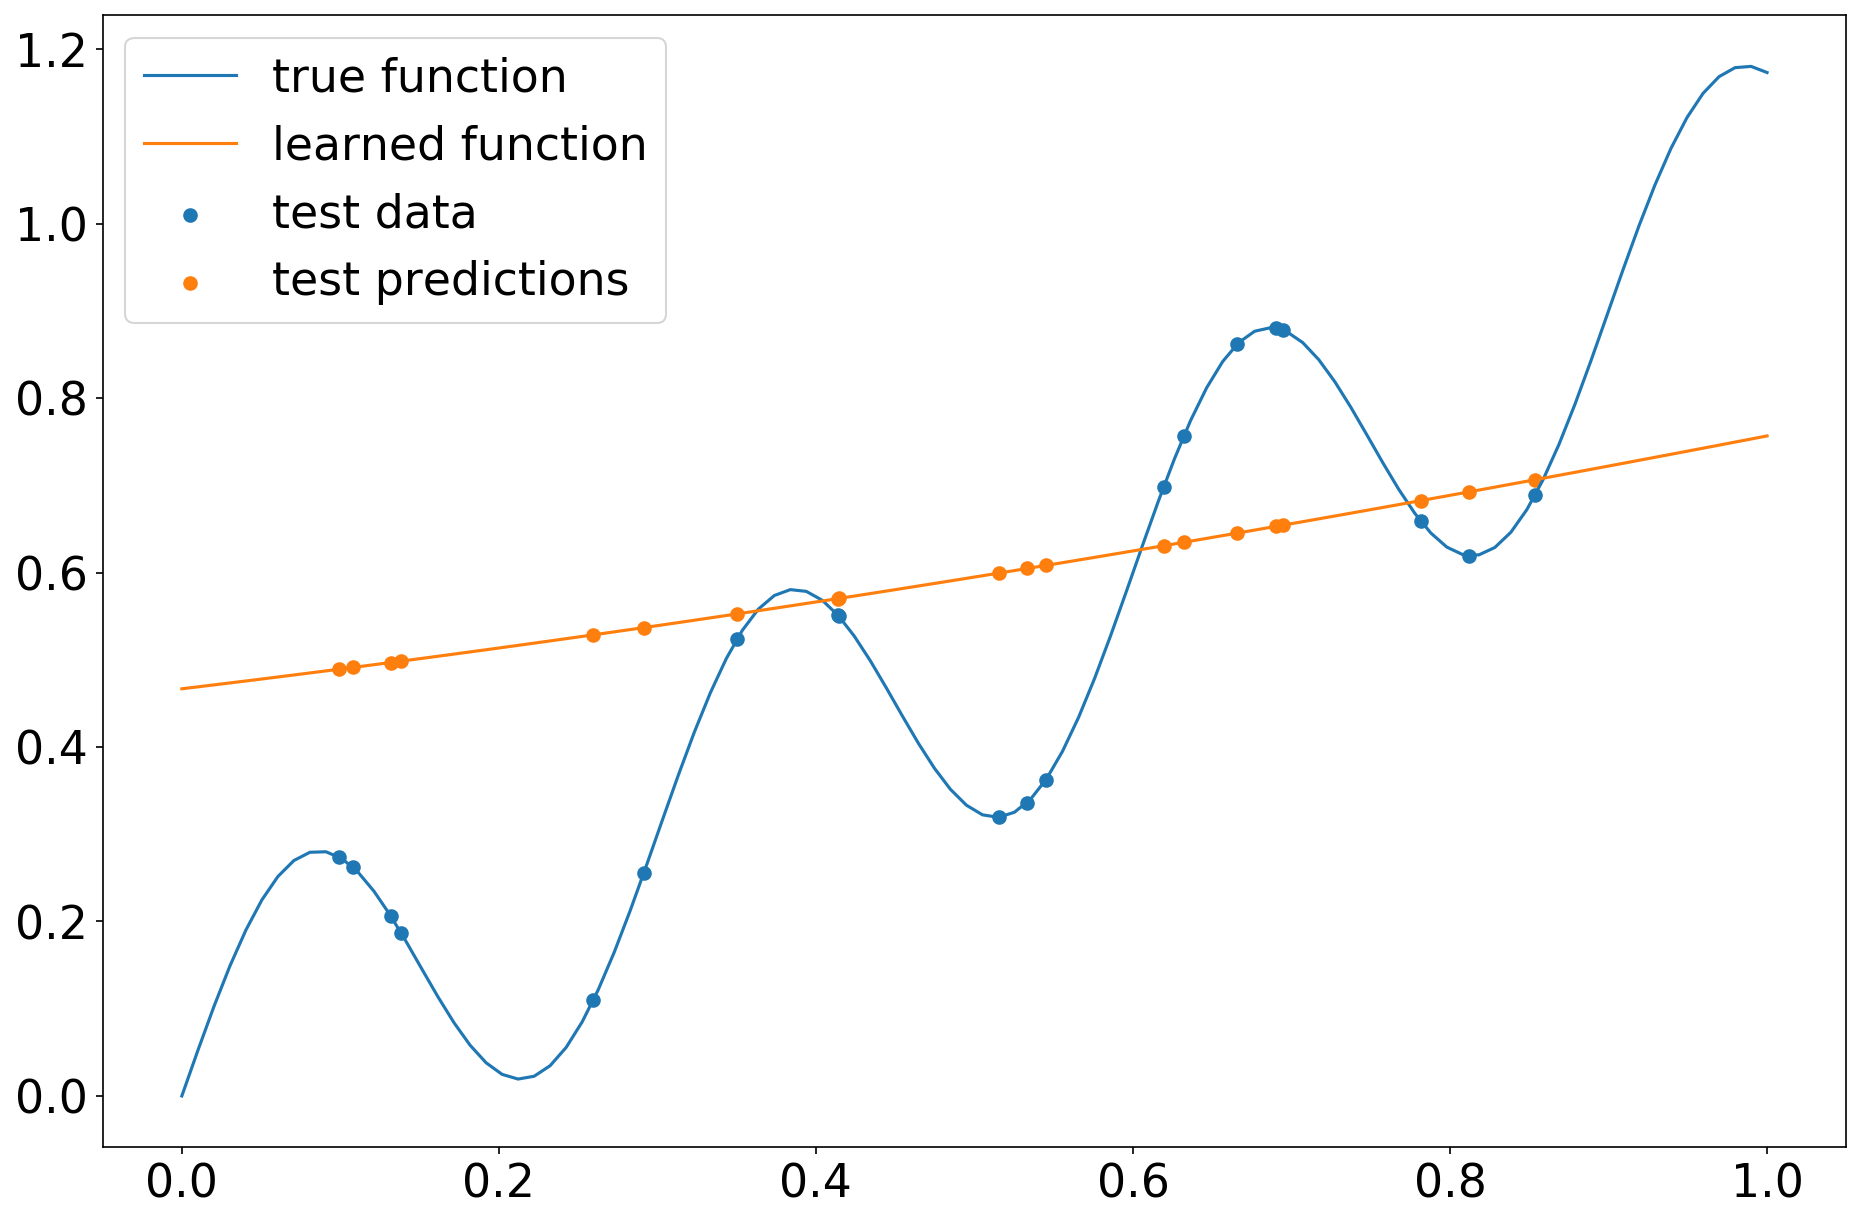

In [20]:
train_and_plot(1e1, 100)